# Discriminator

Run a discrminator network to compare different renditions of showerflow.

## data prep

The starting point is loading the config for this dataset.

In [1]:
import os
import numpy as np
import torch
from pointcloud.config_varients import caloclouds_3, caloclouds_3, wish, default
from pointcloud.evaluation import discriminator
from pointcloud.utils import showerflow_training, showerflow_utils
from pointcloud.utils.metadata import Metadata
from pointcloud.utils.plotting import RatioPlots, nice_hex
from matplotlib import pyplot as plt


default_config = default.Configs()
config = caloclouds_3.Configs()
if torch.cuda.is_available():
    config.device = "cuda"
else:
    config.device = "cpu"
if os.path.exists(os.path.dirname(config.dataset_path)):
    print(f"Found dataset at {config.dataset_path}")
    

Found dataset at /data/dust/user/akorol/data/AngularShowers_RegularDetector/hdf5_for_CC/sim-E1261AT600AP180-180_file_{}slcio.hdf5


Then we check that the ground truth features exist for this dataset.

In [2]:
g4_data_folder = discriminator.locate_g4_data(config)
print(g4_data_folder)
discriminator.create_g4_data_files(config)

/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/discriminator/g4
All g4 data files already exist


Get the generator models we will be comparing with, and check their data has been generated.

In [3]:

stack = []
config.shower_flow_detailed_history = True
for fixed_input_norms in [True, False]:
    for weight_decay in [0., 0.1, 0.0001]:
        config.shower_flow_fixed_input_norms = fixed_input_norms
        config.shower_flow_weight_decay = weight_decay
        stack.append(showerflow_utils.existing_models(config))
        
existing_models = {key: sum([s[key] for s in stack], []) for key in stack[0]}
existing_models["config"] = []

for i, name in enumerate(existing_models["names"]):
    model_config = showerflow_utils.construct_config(config, existing_models, i)
    existing_models["config"].append(model_config)
        
        

Found 3 saved models
Found 3 saved models
Found 3 saved models
Found 3 saved models
Found 3 saved models
Found 3 saved models


In [4]:
from pointcloud.evaluation import discriminator
i=0
data_folder = discriminator.locate_model_data(existing_models["config"][i], existing_models["paths"][i])
print(data_folder)

/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/discriminator/ShowerFlow_original_nb10_inputs8070450532247928831_fnorms_dhist_best


In [5]:
working = []
for i, name in enumerate(existing_models["names"]):
    model_config = existing_models["config"][i]
    path = existing_models["paths"][i]
    print(name, path)
    
    discriminator.create_showerflow_data_files(model_config, path)
    working.append(i)
            
        

original_nb10_fnorms_dhist_wo[0, 1, 4] /data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_original_nb10_inputs8070450532247928831_fnorms_dhist_best.pth
All /data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_original_nb10_inputs8070450532247928831_fnorms_dhist_best.pth data files already exist
alt1_nb2_fnorms_dhist_wo[0, 1, 4] /data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best.pth
All /data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best.pth data files already exist
alt1_nb10_fnorms_dhist_wo[0, 1, 4] /data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sim-E1261AT600AP180-180/ShowerFlow_alt1_nb10_inputs8070450532247928831_fnorms_dhist_best.pth
All /data/dust/user/dayhallh/point-cloud-diffusi

In [7]:
existing_models['names']

['original_nb10_fnorms_dhist_wo[0, 1, 4]',
 'alt1_nb2_fnorms_dhist_wo[0, 1, 4]',
 'alt1_nb10_fnorms_dhist_wo[0, 1, 4]',
 'original_nb10_fnorms_dhist_wd1p0e-01_wo[0, 1, 4]',
 'alt1_nb2_fnorms_dhist_wd1p0e-01_wo[0, 1, 4]',
 'alt1_nb10_fnorms_dhist_wd1p0e-01_wo[0, 1, 4]',
 'original_nb10_fnorms_dhist_wd1p0e-04_wo[0, 1, 4]',
 'alt1_nb2_fnorms_dhist_wd1p0e-04_wo[0, 1, 4]',
 'alt1_nb10_fnorms_dhist_wd1p0e-04_wo[0, 1, 4]',
 'original_nb10_dhist',
 'alt1_nb2_dhist',
 'alt1_nb10_dhist',
 'original_nb10_dhist_wd1p0e-01',
 'alt1_nb2_dhist_wd1p0e-01',
 'alt1_nb10_dhist_wd1p0e-01',
 'original_nb10_dhist_wd1p0e-04',
 'alt1_nb2_dhist_wd1p0e-04',
 'alt1_nb10_dhist_wd1p0e-04']

In [9]:
intrest = ["original_nb10_dhist", "original_nb10_dhist_wd1p0e-04", "original_nb10_dhist_wd1p0e-01"]
idxs = [existing_models["names"].index(i) for i in intrest]
print(list(zip(idxs, intrest)))

[(9, 'original_nb10_dhist'), (15, 'original_nb10_dhist_wd1p0e-04'), (12, 'original_nb10_dhist_wd1p0e-01')]


## data plotting

We can go ahead and create a training object now, as this will load our datasets.
Before we actually start training, we should plot some of the data as a sanity check.

In [10]:

def gen_training(model_idx, settings="settings12"):
    model_name = existing_models["names"][model_idx]
    model_config = existing_models["config"][model_idx]
    model_path = existing_models["paths"][model_idx]
    model_data_folder = discriminator.locate_model_data(model_config, model_path)
    feature_mask = discriminator.feature_masks[settings]
    training = discriminator.Training(settings, g4_data_folder, model_data_folder, discriminator.descriminator_params[settings], feature_mask)
    return model_name, training

first_model, training = gen_training(0)
print(first_model)

g4_test = training._test_dataset.g4_features
gen_test = training._test_dataset.generator_features

cogs = [0, 1, 2]
if training.state_dict["feature_mask"] is not None:
    cogs = np.where(training.state_dict["feature_mask"][:3])[0].tolist()



original_nb10_fnorms_dhist_wo[0, 1, 4]


In [11]:
truth_data = g4_test[:]
truth_data.T[cogs].shape

(2, 2998932)

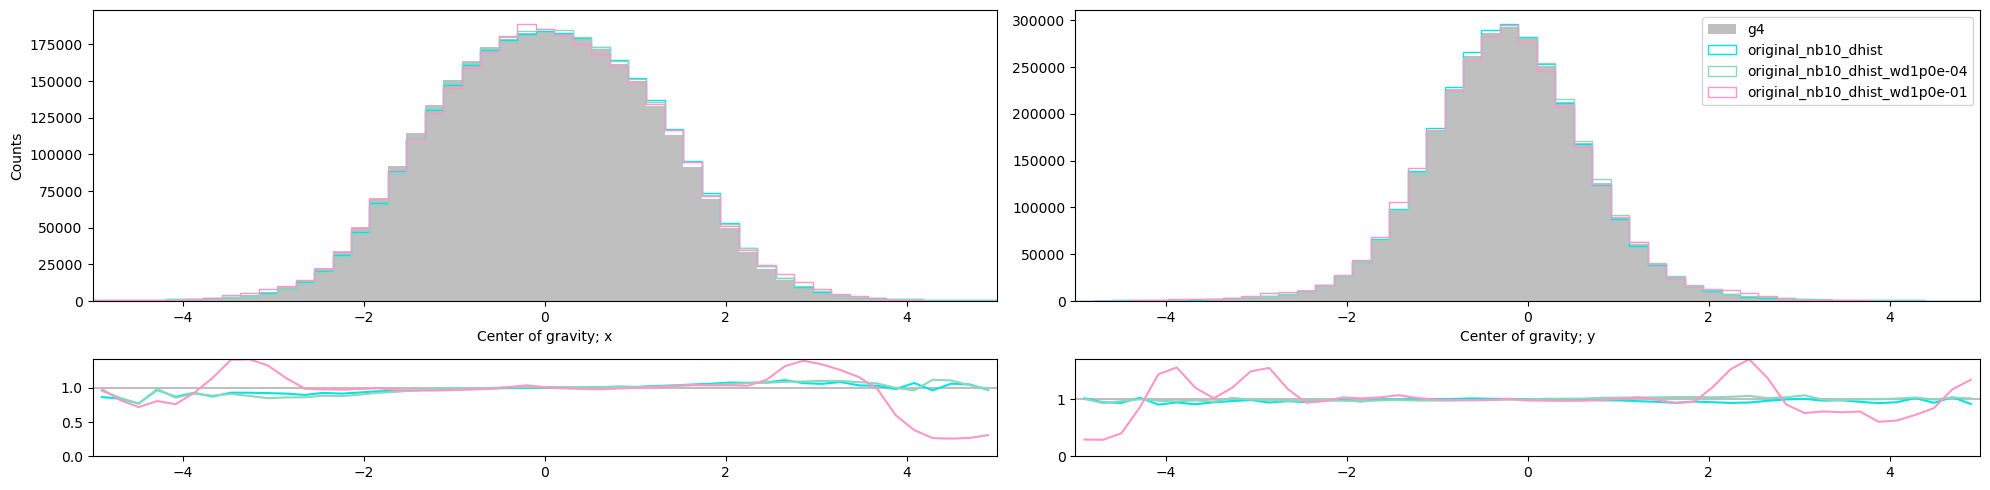

In [12]:

if cogs:
    x_labels = [f"Center of gravity; {c}" for i, c in enumerate("xyz") if i in cogs]
    truth_data = g4_test[:]
    x_ranges = [[-5, 5], [-5, 5], [1750, 2050]]
    #x_ranges = [[-500, 500], [-500, 500], [1750, 2050]]
    x_ranges = [x for i, x in enumerate(x_ranges) if i in cogs]
    ratio_plots = RatioPlots(x_labels, truth_data.T[cogs], x_ranges=x_ranges)
    #ratio_plots = RatioPlots(x_labels, truth_data.T[cogs])
    del truth_data
    for i, model_idx in enumerate(idxs):
        name, training = gen_training(model_idx)
        gen_test = training._test_dataset.generator_features
        gen_data = gen_test[:]
        ratio_plots.add_comparison(gen_data.T[cogs], name, nice_hex[0][i])
        del gen_data
    ratio_plots.finalise()

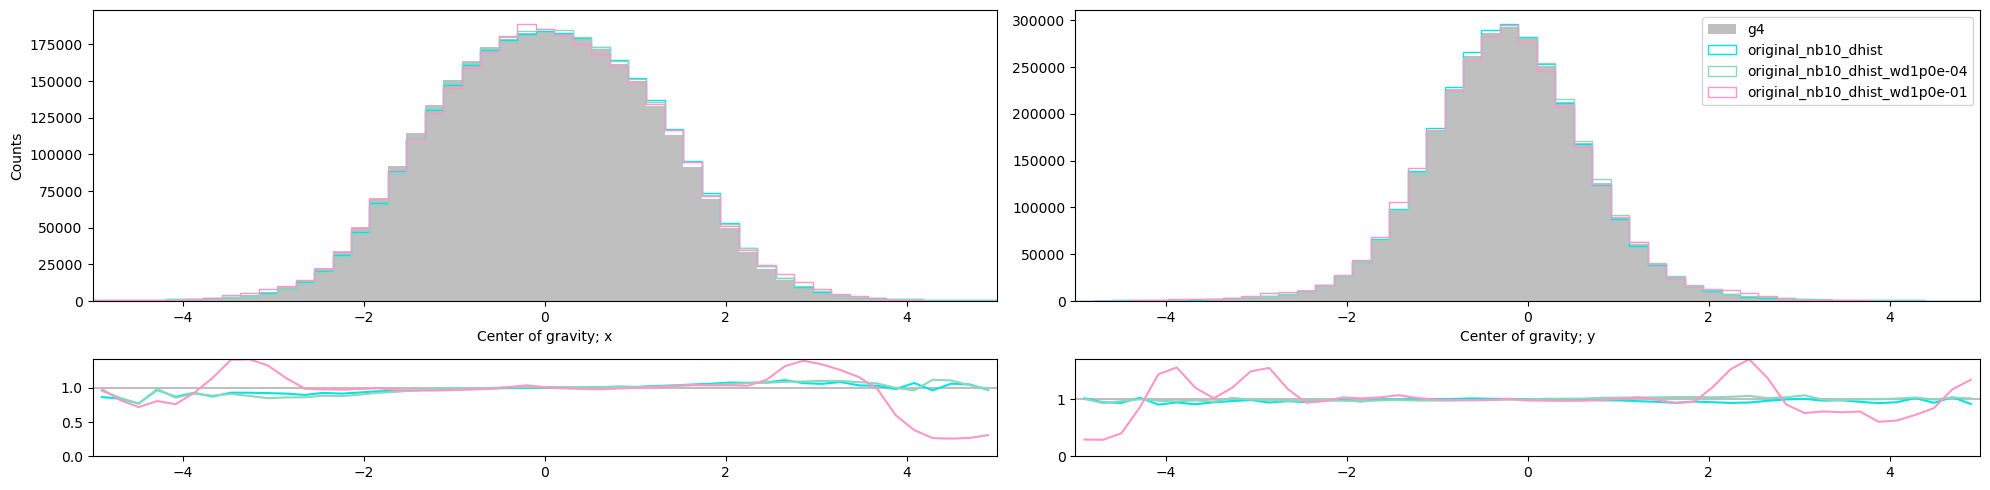

In [13]:

if cogs:
    x_labels = [f"Center of gravity; {c}" for i, c in enumerate("xyz") if i in cogs]
    truth_data = g4_test[:]
    x_ranges = [[-5, 5], [-5, 5], [1750, 2050]]
    #x_ranges = [[-500, 500], [-500, 500], [1750, 2050]]
    x_ranges = [x for i, x in enumerate(x_ranges) if i in cogs]
    ratio_plots = RatioPlots(x_labels, truth_data.T[cogs], x_ranges=x_ranges, logy=True)
    #ratio_plots = RatioPlots(x_labels, truth_data.T[cogs])
    del truth_data
    for i, model_idx in enumerate(idxs):
        name, training = gen_training(model_idx)
        gen_test = training._test_dataset.generator_features
        gen_data = gen_test[:]
        ratio_plots.add_comparison(gen_data.T[cogs], name, nice_hex[0][i])
        del gen_data
    ratio_plots.finalise()

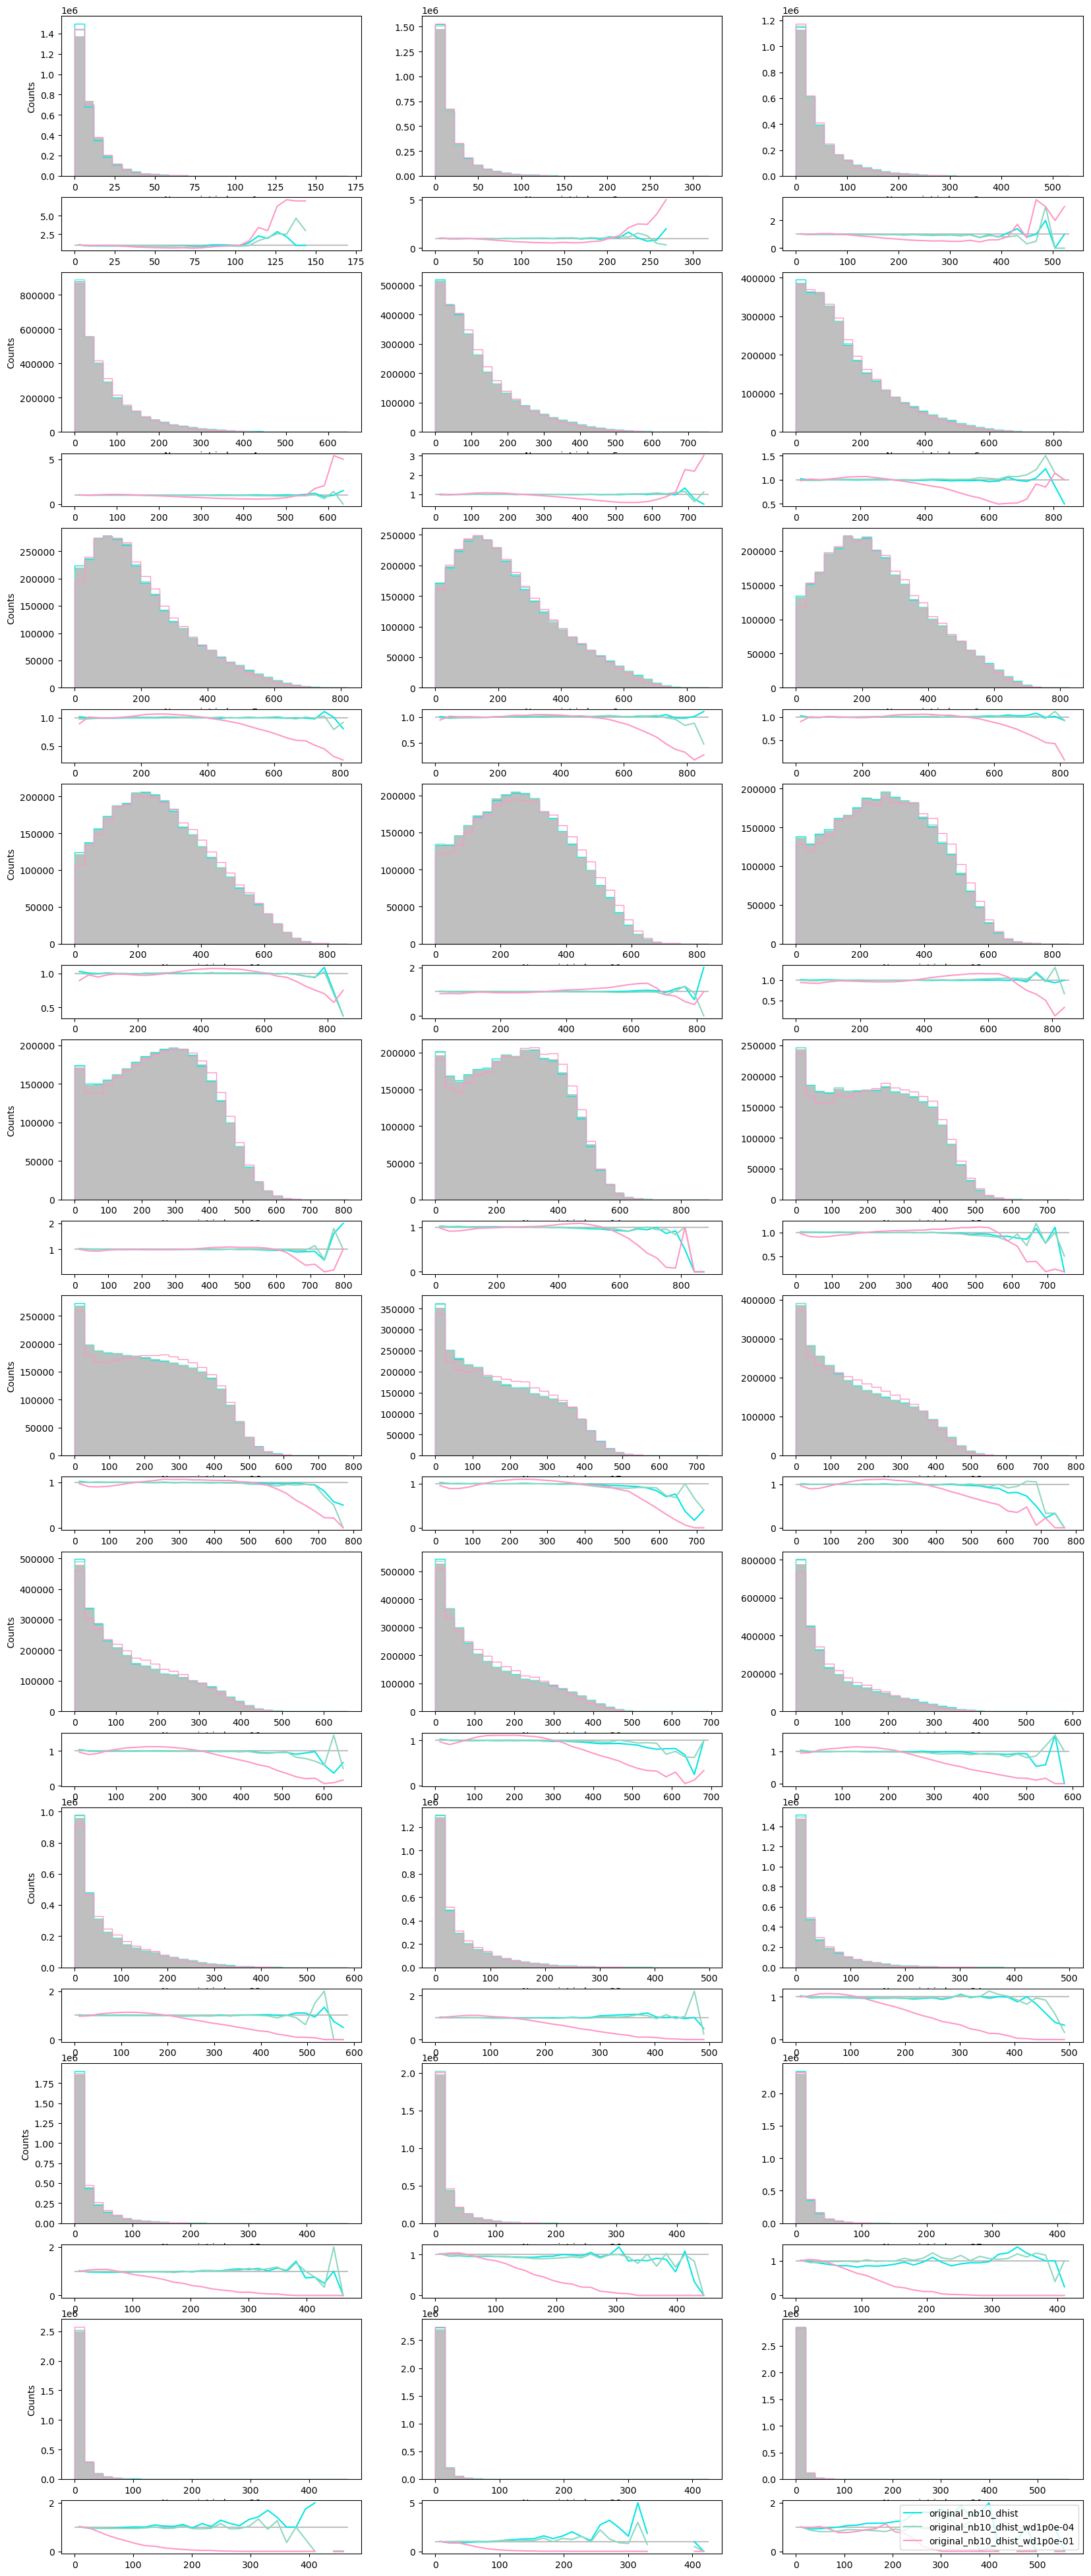

In [14]:


n_cogs = len(cogs)
n_pnts_layers = 30
if training.state_dict["feature_mask"] is not None:
    n_pnts_layers = np.sum(training.state_dict["feature_mask"][3:33])
if n_pnts_layers:
    pnts_slice = slice(n_cogs, n_pnts_layers + n_cogs)
    x_labels = [f"Num point in layer {i}" for i in range(1, n_pnts_layers+1)]
    truth_data = g4_test[:]
    ratio_plots = RatioPlots(x_labels, truth_data.T[pnts_slice], n_bins=30)
    del truth_data
    for i, model_idx in enumerate(idxs):
        name, training = gen_training(model_idx)
        gen_test = training._test_dataset.generator_features
        gen_data = gen_test[:]
        ratio_plots.add_comparison(gen_data.T[pnts_slice], name, nice_hex[0][i])
        del gen_data
    plt.legend()

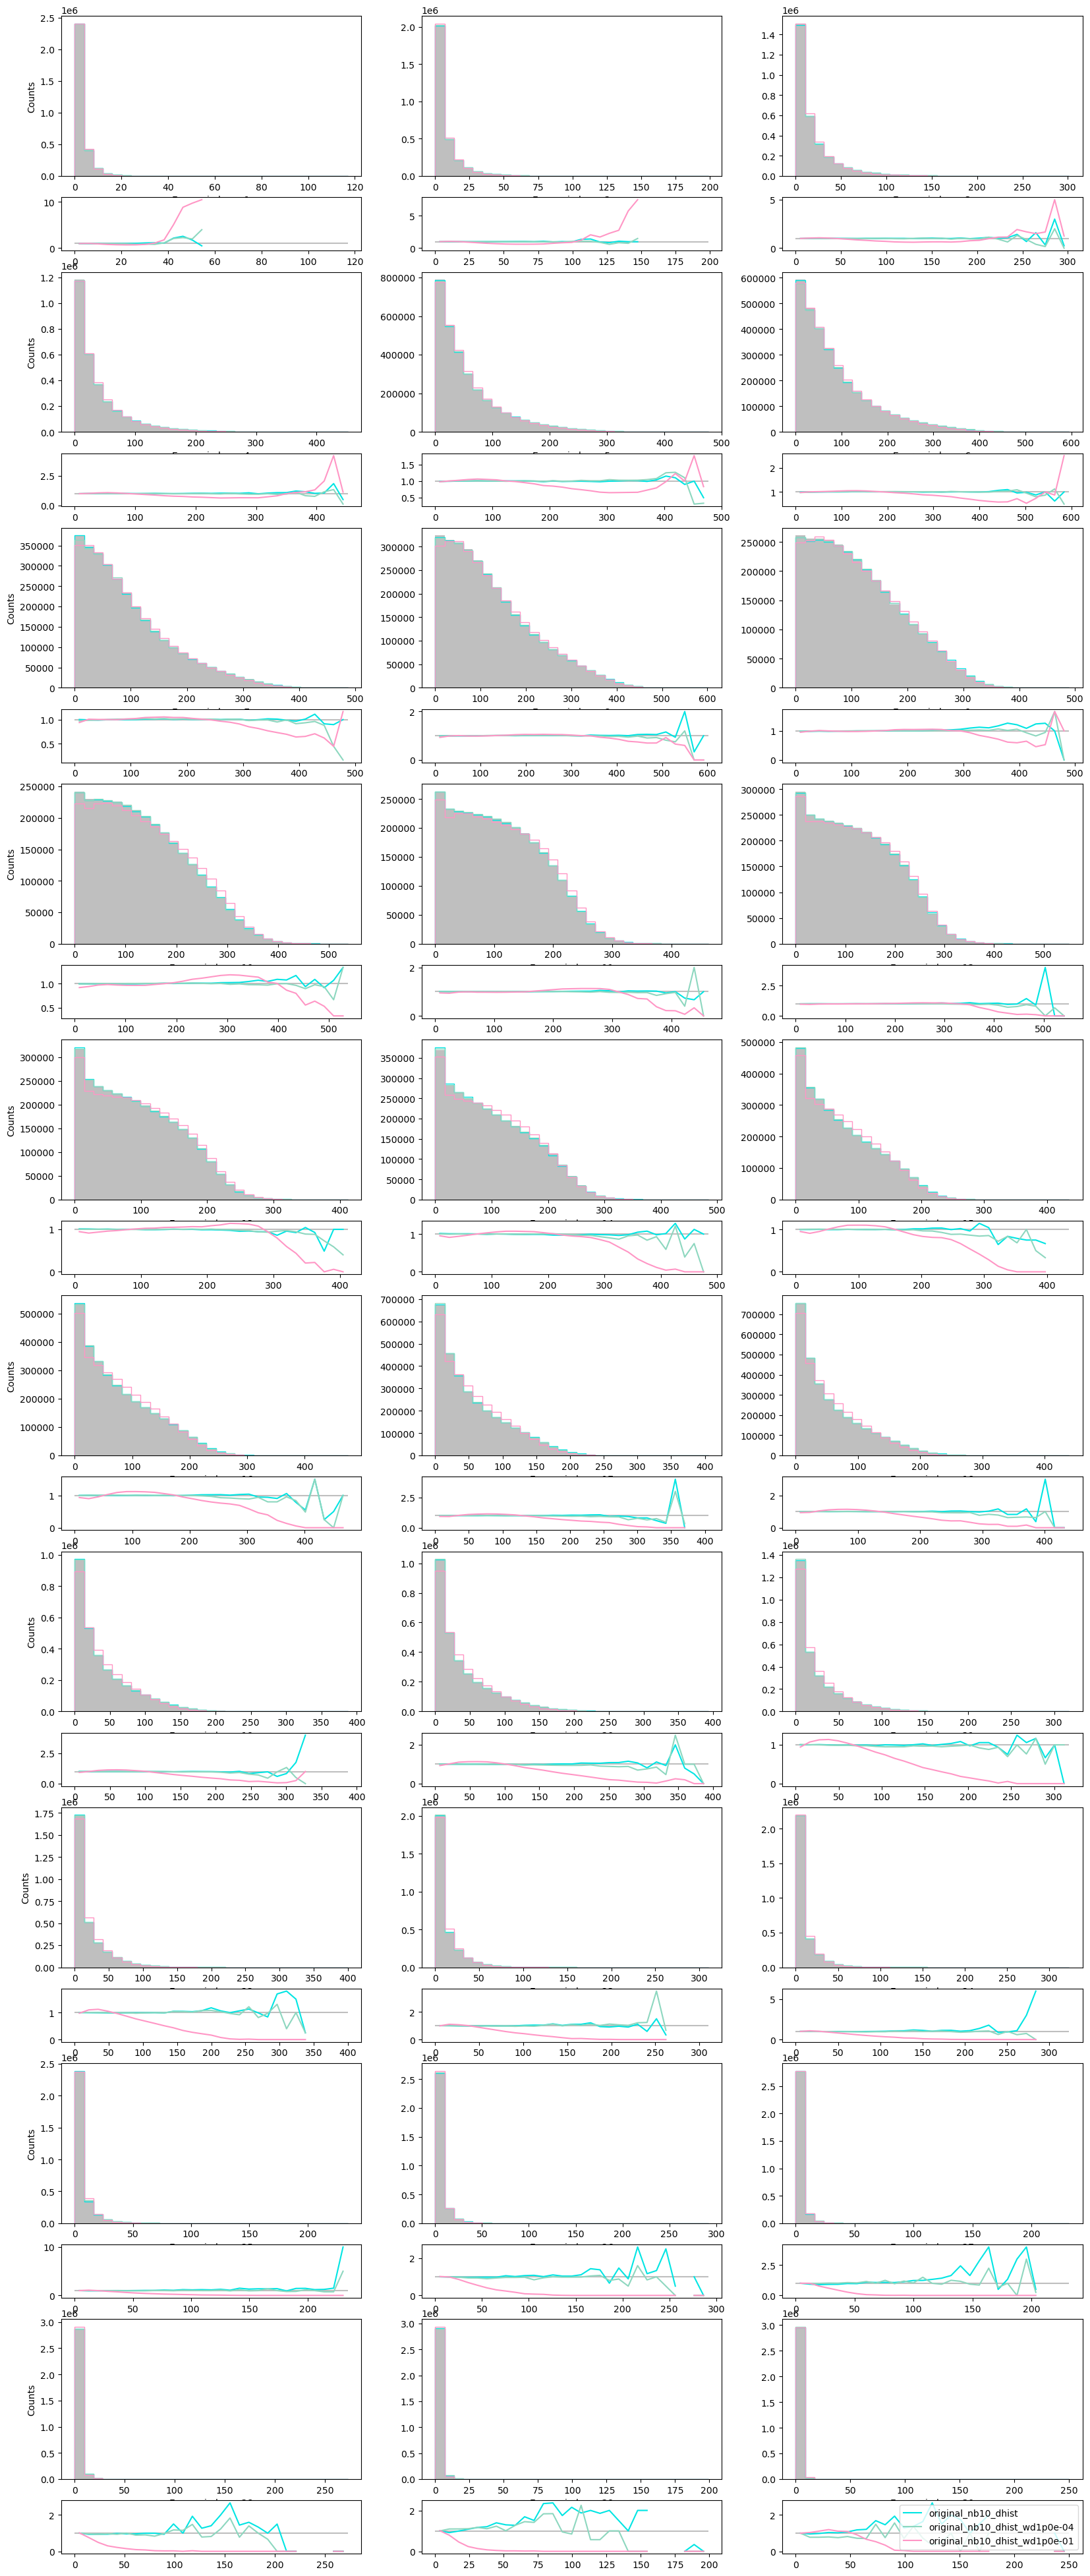

In [15]:


n_cogs = len(cogs)
n_es_layers = 30
if training.state_dict["feature_mask"] is not None:
    n_es_layers = np.sum(training.state_dict["feature_mask"][33:])
if n_es_layers:
    es_slice = slice(n_cogs + n_pnts_layers,None)
    x_labels = [f"Energy in layer {i}" for i in range(1, n_es_layers+1)]
    truth_data = g4_test[:]
    ratio_plots = RatioPlots(x_labels, truth_data.T[es_slice], n_bins=30)
    del truth_data
    for i, model_idx in enumerate(idxs):
        name, training = gen_training(model_idx)
        gen_test = training._test_dataset.generator_features
        gen_data = gen_test[:]
        ratio_plots.add_comparison(gen_data.T[es_slice], name, nice_hex[0][i])
        del gen_data
    plt.legend()

# Training

The data looks fine. Time to launch the training.enumerate

In [16]:
print(list(enumerate(working)))


[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17)]


In [17]:
n_epochs = 1
for i in working:
    print()
    print(f"~~~~~~~~~ {i} ~~~~~~~~~~")
    print()
    name, training = gen_training(i)
    
    try:
        training.reload()
    except FileNotFoundError as e:
        print(e)
    so_far = len(training.state_dict["epochs"])
    print(so_far)
    if False and so_far < n_epochs:
        training.train(n_epochs - so_far)
        training.save()


~~~~~~~~~ 0 ~~~~~~~~~~

5

~~~~~~~~~ 1 ~~~~~~~~~~

8

~~~~~~~~~ 2 ~~~~~~~~~~

8

~~~~~~~~~ 3 ~~~~~~~~~~

8

~~~~~~~~~ 4 ~~~~~~~~~~

8

~~~~~~~~~ 5 ~~~~~~~~~~

23

~~~~~~~~~ 6 ~~~~~~~~~~

23

~~~~~~~~~ 7 ~~~~~~~~~~

24

~~~~~~~~~ 8 ~~~~~~~~~~

24

~~~~~~~~~ 9 ~~~~~~~~~~

8

~~~~~~~~~ 10 ~~~~~~~~~~

11

~~~~~~~~~ 11 ~~~~~~~~~~

11

~~~~~~~~~ 12 ~~~~~~~~~~

3

~~~~~~~~~ 13 ~~~~~~~~~~

[Errno 2] No such file or directory: '/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/discriminator/ShowerFlow_alt1_nb2_inputs36893488147419103231_dhist_wd1p0e-01_best/settings12.pt'
0

~~~~~~~~~ 14 ~~~~~~~~~~

[Errno 2] No such file or directory: '/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/discriminator/ShowerFlow_alt1_nb10_inputs36893488147419103231_dhist_wd1p0e-01_best/settings12.pt'
0

~~~~~~~~~ 15 ~~~~~~~~~~

[Errno 2] No such file or directory: '/data/dust/user/dayhallh/point-cloud-diffusion-logs/sim-E1261AT600AP180-180/discriminator/ShowerF

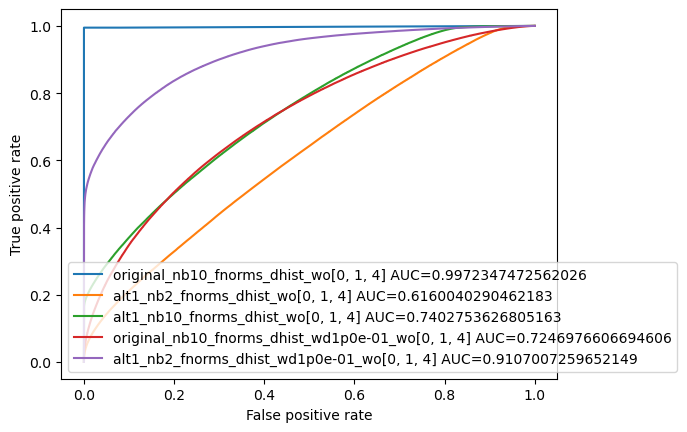

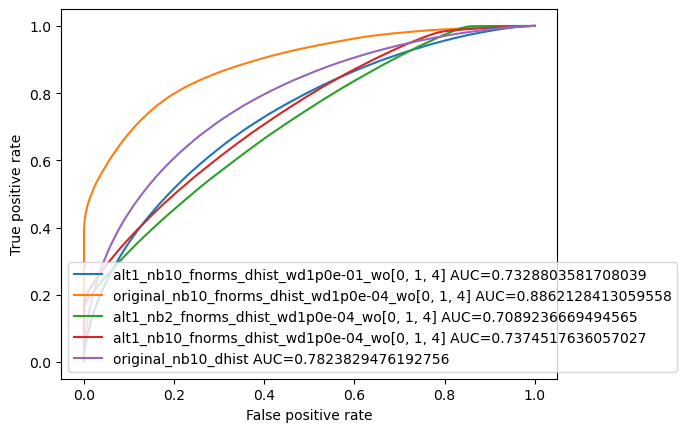

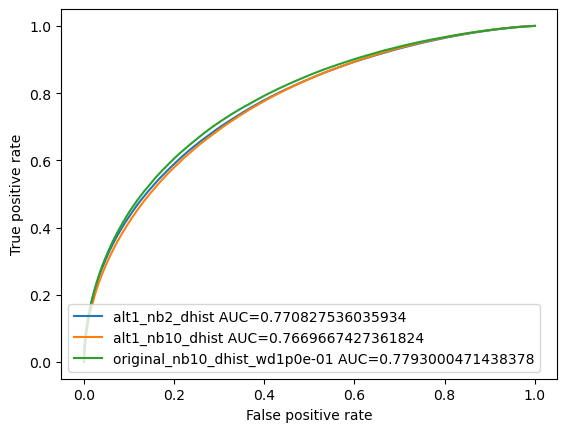

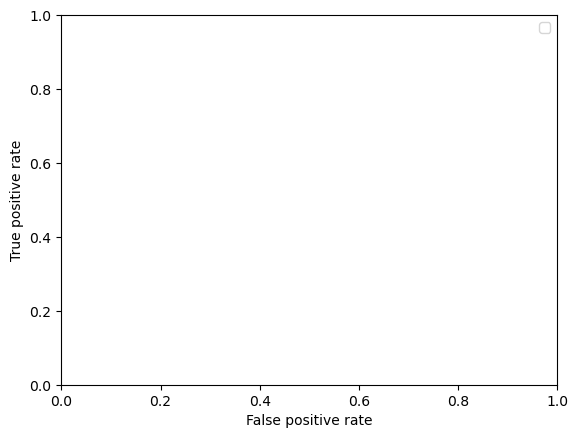

In [18]:
from sklearn import metrics
from matplotlib import pyplot as plt
existing_models["auc"] = [None for _ in existing_models["names"]]
for start in range(0,len(existing_models["names"]), 5):
    fig, ax = plt.subplots()
    for i in range(start, start+5):
        try:
            plot_for = working[i]
        except IndexError:
            continue
        try:
            name, training = gen_training(plot_for)
            training.reload()
            labels, predictions = training.predict_test()
        except FileNotFoundError:
            continue
        
        fpr, tpr, threasholds = metrics.roc_curve(labels, predictions)
        auc = metrics.roc_auc_score(labels, predictions)
        if auc < 0.501:
            print(f"Model {plot_for} has issues")
        existing_models["auc"][plot_for] = auc
        ax.plot(fpr, tpr, label=f"{name} AUC={auc}")
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.legend()



ValueError: Invalid RGBA argument: np.float64(0.5)

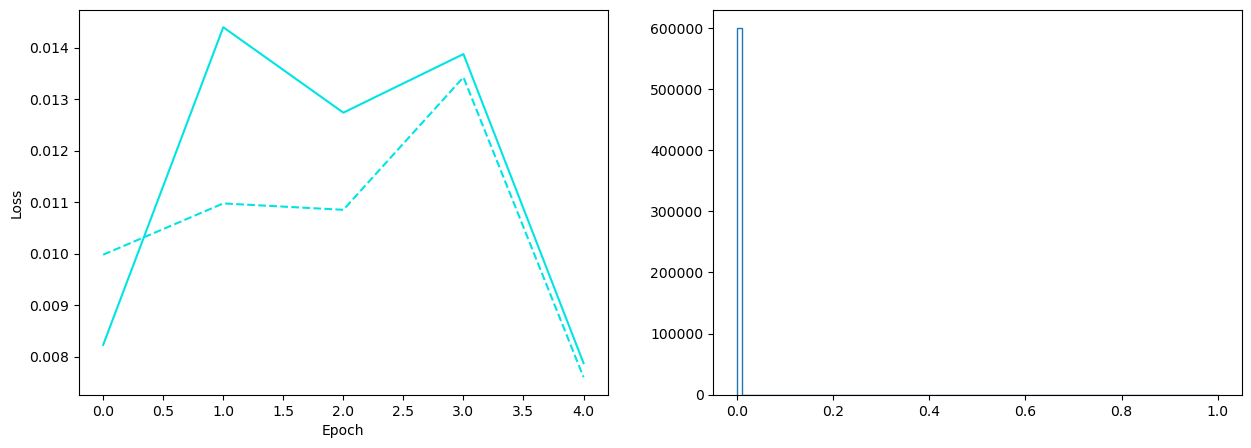

In [19]:
for start in range(0, len(existing_models["names"]), 5):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for i in range(start, start+5):
        try:
            plot_for = working[i]
        except IndexError:
            continue
        try:
            name, training = gen_training(plot_for)
            training.reload()
            training.plots(axes, colour=nice_hex[int(i/5)%5][i%5], legend_name=name)
        except FileNotFoundError:
            continue
    axes[0].semilogy()
    axes[0].set_xlim(0, 30)
    axes[1].semilogy()
    axes[0].legend()
    axes[1].legend()

In [ ]:
if False:
    import ot
    
    first_model, training = gen_training(5)
    print(first_model)
    
    g4_test = training._test_dataset.g4_features
    gen_test = training._test_dataset.generator_features
    
    n_events = 10000
    truth_data = g4_test[:n_events]
    gen_data = gen_test[:n_events]
    
    n_seed = 10
    n_projections_arr = np.logspace(0, 3, 10, dtype=int)
    res = np.empty((n_seed, 10))
    
    for seed in range(n_seed):
        print(f"seed = {seed}")
        for i, n_projections in enumerate(n_projections_arr):
            print(f"{i/10:.1%}", end="\r")
            res[seed, i] = ot.sliced_wasserstein_distance(truth_data, gen_data, n_projections=n_projections, seed=seed)
        print()
    
    res_mean = np.mean(res, axis=0)
    res_std = np.std(res, axis=0)



In [ ]:
if False:
    from matplotlib import pyplot as plt
    plt.figure(2)
    plt.plot(n_projections_arr, res_mean, label="SWD")
    plt.fill_between(n_projections_arr, res_mean - 2 * res_std, res_mean + 2 * res_std, alpha=0.5)
    plt.legend()
    plt.xscale('log')
    plt.xlabel("Number of projections")
    plt.ylabel("Distance")
    plt.title('Sliced Wasserstein Distance with 95% confidence interval')
    plt.show()
    


In [ ]:
if False:
    import ot
    
    g4_test = training._test_dataset.g4_features
    n_events = 10000
    truth_data = g4_test[:n_events]
    n_projections = 1000
    n_working = len(working)
    n_seeds = 10
    distances = np.empty((n_working, n_seeds))
    for i, w in enumerate(working):
        print(f"{i/n_working:.1%}", end="\r")
        try:
            name, training = gen_training(w)
        except Exception as e:
            print()
            print(e)
            print()
            
        gen_test = training._test_dataset.generator_features
        gen_data = gen_test[:n_events]
        for seed in range(n_seeds):
            distances[i, seed] = ot.sliced_wasserstein_distance(truth_data, gen_data, n_projections=n_projections, seed=seed)



In [ ]:
if False:
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = plt.cm.tab10
    heights = np.linspace(np.min(distances), np.max(distances), n_working)
    
    for i, w in enumerate(working):
        name = existing_models["names"][w]
        distance = np.mean(distances[i])
        distance_err = np.std(distances[i])
        loss = existing_models["best_loss"][w]
        c = cmap(i/n_working)
        plt.text(loss, distance, name,
                 rotation=-20, rotation_mode='anchor',
                 color=c
                )
        n_blocks = existing_models["num_blocks"][w]
        plt.plot([loss, loss], [distance-distance_err, distance+distance_err], lw=n_blocks,
                 c=c)
    
    plt.ylabel("Sliced Wasserstein")
    plt.xlabel("Best loss")